<a href="https://colab.research.google.com/github/VinaySingh561/LARGE-LANGUAGE-MODELS/blob/main/Coding_the_entire_GPT_model%5B124million%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn

In [28]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [29]:
class Layernorm(nn.Module):  ## every row will have mean of zero and std of 1
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1, keepdim = True)
    var = x.var(dim=-1, keepdim = True)
    norm_x = (x - mean)/torch.sqrt(var + self.eps)
    return self.scale*norm_x  + self.shift


class GELU(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return 0.5*x*(1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+ 0.044715 * torch.pow(x,3))
    ))


class FeedForward(nn.Module):
  def __init__(self,CFG):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(CFG["emb_dim"], 4*CFG["emb_dim"]),
        GELU(),
        nn.Linear(4*CFG["emb_dim"],CFG["emb_dim"] )
    )

  def forward(self, x):
    return self.layers(x)

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

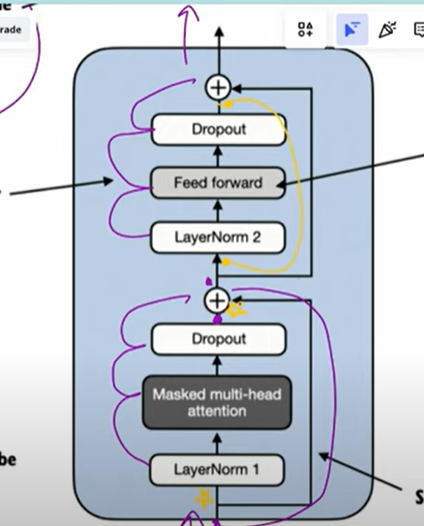

In [31]:
class TransfomerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in  = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length=  cfg['context_length'],
        num_heads=cfg['n_heads'],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg['qkv_bias']
    )
    self.ff = FeedForward(cfg)
    self.norm1 = Layernorm(cfg["emb_dim"])
    self.norm2 = Layernorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])


  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x) ## it will return ccontext vector of that input (batch_sze, num_tokens, embsize)
    x = self.drop_shortcut(x)
    x = x  + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x +  shortcut

    return x


In [32]:
torch.manual_seed(123)
x = torch.randn(2,4,768)
LLM  = TransfomerBlock(GPT_CONFIG_124M)
output  = LLM(x)
print("Input shape  : ", x.shape)
print("Output shape :", output.shape)

Input shape  :  torch.Size([2, 4, 768])
Output shape : torch.Size([2, 4, 768])


# coding the entire GPT Model

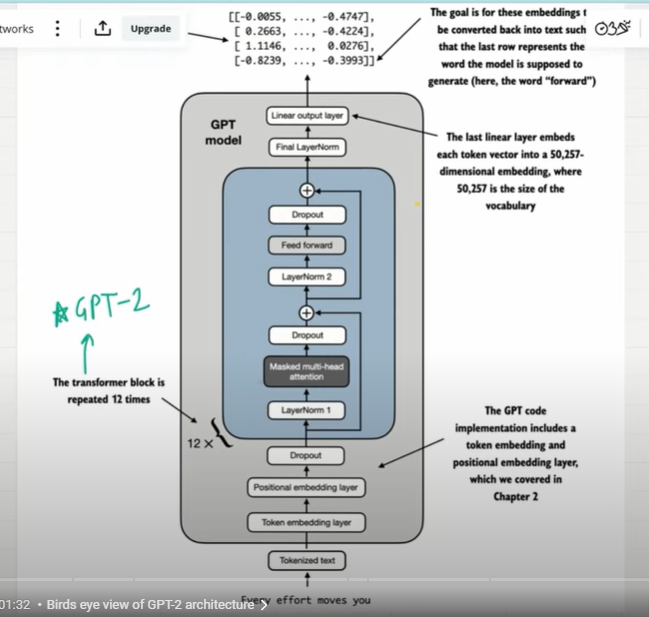

In [33]:
class GPTmodel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransfomerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = Layernorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg['vocab_size'], bias  = False)


  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits= self.out_head(x)
    return logits

In [34]:
# !pip install tiktoken

In [35]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "You are wonderful lady"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch.shape)

torch.Size([2, 4])


In [36]:
torch.manual_seed(123)
model  = GPTmodel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\n Output shape:", out.shape)

Input batch:
 tensor([[ 6109,  3626,  6100,   345],
        [ 1639,   389,  7932, 10846]])

 Output shape: torch.Size([2, 4, 50257])


In [37]:
## find the total number of params in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters:{total_params:,}")

Total number of parameters:163,009,536


In [38]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [39]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [40]:
## size of the model
total_size_bytes = total_params*4
total_size_mb = total_size_bytes/(1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [41]:
## Generating text from output tokens

In [45]:
def predict_next_tokens(model, idx, max_num_tokens, context_length):
  for _ in range(max_num_tokens):


    with torch.no_grad():
      logits = model(idx[:,-context_length:])

    # focus only on the last logit,
    logits = logits[:,-1,:] ## it lies in the second dim , not vocab size(third dim)

    # softmax
    probs = torch.softmax(logits,dim=-1)
    # choose the highest one
    next_idx = torch.argmax(probs, dim=-1, keepdim = True) # batch, 1

    idx = torch.cat((idx, next_idx), dim=1)
  return idx

In [46]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("Encoded tensor shape :", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
Encoded tensor shape : torch.Size([1, 4])


In [47]:
model.eval() # to swtich off drop out and layer norm which are running batch stats
out  = predict_next_tokens(model, encoded_tensor,max_num_tokens=
                           6, context_length=GPT_CONFIG_124M['context_length'])
print("Output : ", out)
print("Output length : ", len(out[0]))

Output :  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length :  10


In [49]:
decoded_output = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded output : ", decoded_output)

Decoded output :  Hello, I am Featureiman Byeswickattribute argue
